Found 5690 files belonging to 24 classes.
Found 1208 files belonging to 24 classes.
Found 1244 files belonging to 24 classes.
Train Clean Accuracy: 98.88%
Validation Clean Accuracy: 86.75%
Test Clean Accuracy: 83.52%
Epsilon: 0.00 | Clean accuracy: 83.52% | Adversarial accuracy: 10.29%


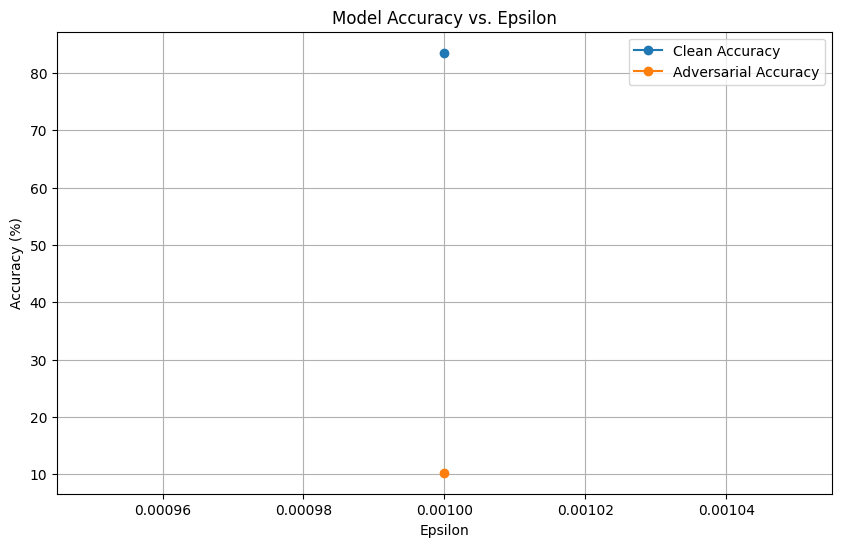

Figure saved at O:/project/dataset/pgd_mobile_adam_fined_e50\accuracy_vs_epsilon.png
Results saved at O:/project/dataset/pgd_mobile_adam_fined_e50\accuracy_results.txt


In [1]:
##################################################################################3
### guide :
### this file load model and dataset and apply pgd attack on it and saves the results
### if want to save the adv_images check for commented line in evaluate_functon
### if model should load in specific way check for load model which highlighted by a comment
### dataset format should be like VGGFace2

import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

########################################################################
#  Parameters
train_dir = 'O:/project/dataset/train'
val_dir = 'O:/project/dataset/val'    
test_dir = 'O:/project/dataset/test' 
base_save_dir = 'O:/project/dataset/pgd_mobile_adam_fined_e50'
model_path = 'O:/project/epochs/check_mobilenetv2_adam_4_e50_fined_50/model_epoch_50.keras'
img_height = 160 
img_width = 160  
batch_size = 64  
epsilon_values = [0.001]



os.makedirs(base_save_dir, exist_ok=True)

def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int',
        shuffle=False 
    )
    
    file_paths = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(root, file))

    file_paths.sort()  
    return dataset, file_paths

train_dataset, train_file_paths = load_dataset(train_dir)
val_dataset, val_file_paths = load_dataset(val_dir)
test_dataset, test_file_paths = load_dataset(test_dir)

class_names = test_dataset.class_names
num_classes = len(class_names)

def preprocess_label(label):
    return tf.one_hot(label, num_classes)

def preprocess_data(x, y):
    x = x * (1. / 255)
    y = preprocess_label(y)
    return x, y

train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

def pgd_attack(model, x, y, epsilon, alpha=0.01, iterations=5):
    adv_x = x
    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_x)
            prediction = model(adv_x)
            loss = tf.keras.losses.categorical_crossentropy(y, prediction)
        
        gradient = tape.gradient(loss, adv_x)
        signed_grad = tf.sign(gradient)
        adv_x = adv_x + alpha * signed_grad
        
        adv_x = tf.clip_by_value(adv_x, x - epsilon, x + epsilon)
        
        adv_x = tf.clip_by_value(adv_x, 0, 1)
    
    return adv_x

def evaluate_clean_accuracy(model, dataset):
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    for x_batch, y_batch in dataset:
        predictions = model(x_batch)
        accuracy.update_state(y_batch, predictions)
    return accuracy.result().numpy() * 100

def evaluate_and_save(model, dataset, file_paths, epsilon, save_dir):
    clean_accuracy = tf.keras.metrics.CategoricalAccuracy()
    adv_accuracy = tf.keras.metrics.CategoricalAccuracy()

    os.makedirs(save_dir, exist_ok=True)

    for batch_index, (x_batch, y_batch) in enumerate(dataset):
        start_idx = batch_index * batch_size
        end_idx = start_idx + x_batch.shape[0]
        image_paths = file_paths[start_idx:end_idx]

        x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon)

        clean_predictions = model(x_batch)
        clean_accuracy.update_state(y_batch, clean_predictions)

        adv_predictions = model(x_adv_batch)
        adv_accuracy.update_state(y_batch, adv_predictions)

    clean_acc = clean_accuracy.result().numpy() * 100
    adv_acc = adv_accuracy.result().numpy() * 100
    print(f"Epsilon: {epsilon:.2f} | Clean accuracy: {clean_acc:.2f}% | Adversarial accuracy: {adv_acc:.2f}%")
    
    return clean_acc, adv_acc

# Load your model
model = tf.keras.models.load_model(model_path)

train_clean_accuracy = evaluate_clean_accuracy(model, train_dataset)
val_clean_accuracy = evaluate_clean_accuracy(model, val_dataset)
test_clean_accuracy = evaluate_clean_accuracy(model, test_dataset)

print(f"Train Clean Accuracy: {train_clean_accuracy:.2f}%")
print(f"Validation Clean Accuracy: {val_clean_accuracy:.2f}%")
print(f"Test Clean Accuracy: {test_clean_accuracy:.2f}%")

clean_accuracies = []
adv_accuracies = []

for epsilon in epsilon_values:
    epsilon_save_dir = os.path.join(base_save_dir, f'epsilon_{epsilon}')
    clean_acc, adv_acc = evaluate_and_save(model, test_dataset, val_file_paths, epsilon, epsilon_save_dir)
    clean_accuracies.append(clean_acc)
    adv_accuracies.append(adv_acc)

figure_path = os.path.join(base_save_dir, 'accuracy_vs_epsilon.png')
results_txt_path = os.path.join(base_save_dir, 'accuracy_results.txt')

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, clean_accuracies, label='Clean Accuracy', marker='o')
plt.plot(epsilon_values, adv_accuracies, label='Adversarial Accuracy', marker='o')
plt.title('Model Accuracy vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.savefig(figure_path)
plt.show()

with open(results_txt_path, 'w') as f:
    f.write(f"Train Clean Accuracy: {train_clean_accuracy:.2f}%\n")
    f.write(f"Validation Clean Accuracy: {val_clean_accuracy:.2f}%\n")
    f.write(f"Test Clean Accuracy: {test_clean_accuracy:.2f}%\n\n")
    
    for epsilon, clean_acc, adv_acc in zip(epsilon_values, clean_accuracies, adv_accuracies):
        f.write(f"Epsilon: {epsilon:.2f} | Clean accuracy: {clean_acc:.2f}% | Adversarial accuracy: {adv_acc:.2f}%\n")

print(f"Figure saved at {figure_path}")
print(f"Results saved at {results_txt_path}")
